[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UBi-courses/essentials-bioinformatics-2025/blob/main/practicos/day2/2BC_Long_Read_Quantification/practico2B_colab.ipynb)



# 🧮 Practical 2B - Long-Read Transcriptomics QC and Alignment (Google Colab)

This notebook guides you through a student-friendly pipeline for long-read RNA quality analysis of ONT cDNA data, using **NanoPack** (ONT cDNA), **chopper**, **minimap2**, **samtools**, **featureCounts**, and **StringTie2**.  

**Please read the quick rules:**  
- **Each student must make their own copy in their own Drive**: *File → Save a copy in Drive*.  
- **Run cells from top to bottom.** If the runtime disconnects, re-run the setup cells (Drive mount, installs).  
- **Save heavy outputs to your own Drive** (see the `Save results to Drive` cell).  
- We are using smaller datasets (e.g. sliced for one chromosome).




## Student checklist (start here)
- ✅ Open this notebook link and do **File → Save a copy in Drive** (work on your own copy).
- ✅ Keep **paths** consistent: edit them if necessary.
- ✅ Always **mount your Drive** before accessing or saving files.
- ✅ If you see `ModuleNotFoundError` or `command not found`, re-run the **Install tools** cell.
- ✅ In Colab you can see your file system explorer. By default, Google Colab starts in the `/content` directory. This is the root directory where you can perform various operations.


## 0) Mount Google Drive (required)
This will attach *your* Google Drive under `/content/drive`. If you see a prompt, follow the link and paste the authorization code.


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
!echo "Drive mounted at: /content/drive"
!ls -lah /content/drive | sed -n '1,40p'



## 1) Dataset to be used

### **Shared Drive folder** (read‑only)
We are providing a folder link (read‑only).
`https://drive.google.com/drive/folders/1NzJFYwlJAC1ikHnFsf6NbLXH4-rGfJS9?usp=sharing`
ℹ️ Tip: Right‑click the shared folder in Drive → **Add shortcut to Drive** → place it under *MyDrive* and then re-organize/move if needed.


In [ ]:
# --- check path dataset ---
SHARED_FOLDER_PATH = "/content/drive/MyDrive/0_CURSO_UBi_LongReads_Transcriptomics/PRACTICO2B"
!echo "Listing shared folder (if it exists):"
!ls -lah "$SHARED_FOLDER_PATH" || echo "Shared folder not found."

import os
os.environ["SHARED_FOLDER_PATH"] = SHARED_FOLDER_PATH

In [ ]:
!echo $SHARED_FOLDER_PATH


## 2) Install tools (run once per fresh session)
Installs **minimap2**, **samtools**, **featureCounts** (subread), and Python package for **NanoPack**.


In [ ]:
%%bash
set -euo pipefail
sudo apt-get update -qq
sudo apt-get install -y -qq minimap2 samtools subread pigz

In [ ]:
!pip install nanopack pysam pandas

In [ ]:

# Check versions
!echo "minimap2:"; minimap2 --version
!echo "samtools:"; samtools --version | head -n 1
!echo "featureCounts:"; featureCounts -v | head -n 1
import nanoplot, nanostat, nanofilt, sys
print("Python libs OK: NanoPack")


In [ ]:
%%bash
set -euo pipefail

#Descargar a /usr/local/bin la release mas reciente
cd /usr/local/bin
wget -q https://github.com/wdecoster/chopper/releases/download/v0.11.0/chopper-linux
chmod +x chopper-linux
chopper-linux --version


In [ ]:
%%bash
set -euo pipefail

#Descargar a /usr/local/bin la release mas reciente
cd /usr/local/bin
wget -q https://ccb.jhu.edu/software/stringtie/dl/stringtie-3.0.1.Linux_x86_64.tar.gz
tar -xvzf stringtie-3.0.1.Linux_x86_64.tar.gz
chmod +x stringtie-3.0.1.Linux_x86_64/stringtie
ln -s stringtie-3.0.1.Linux_x86_64/stringtie stringtie
stringtie --version

## 3) Select one fastq file

Select one of the fastq files and copy it to your `/content` directory.

In [ ]:
!pwd

In [ ]:
!mkdir data
!mkdir output  ##podes generar un lugar para guardar en Drive

In [ ]:

##copy three fastq files to /content/data in Colab (e.g. three replicates of the same cell line)
!ls {SHARED_FOLDER_PATH}/fastq_raw/SGNex_H9_cDNA_*_sub.fastq.gz #edit as needed
!cp {SHARED_FOLDER_PATH}/fastq_raw/SGNex_H9_cDNA_*_sub.fastq.gz data/

##select one of the fastq files
MYFASTQ = "/content/data/SGNex_H9_cDNA_replicate3_run4_sub.fastq.gz"    #edit as needed
os.environ["MYFASTQ"] = MYFASTQ


## 4) QC with NanoPack
Performing quality control at this stage is essential to ensure that only high-quality reads are used for alignment and quantification, reducing noise and improving the reliability of transcriptomic results.

NanoPack is a suite of tools designed for quality control and visualization of long-read sequencing data. It allows users to inspect read length, quality, and yield distributions, providing an overview of run performance and potential technical biases.

🧩 Run NanoPlot for basic stats and plots of filtered reads.


In [ ]:

%%bash
set -euo pipefail
echo "Running NanoStat..."
NanoStat --fastq "$MYFASTQ" > "output/nanostat_raw.txt"
echo "Running NanoPlot..."
mkdir -p "output/nanoplot_raw"
NanoPlot --fastq "$MYFASTQ" --loglength --outdir "output/nanoplot_raw" --threads "$(nproc)"


The output folder will contain many figures and a summary file `NanoPlot-report.html`. Open the file and find the plot showing *Read length vs Average read quality using kernel density*.
I am also attaching this figure for another sample:
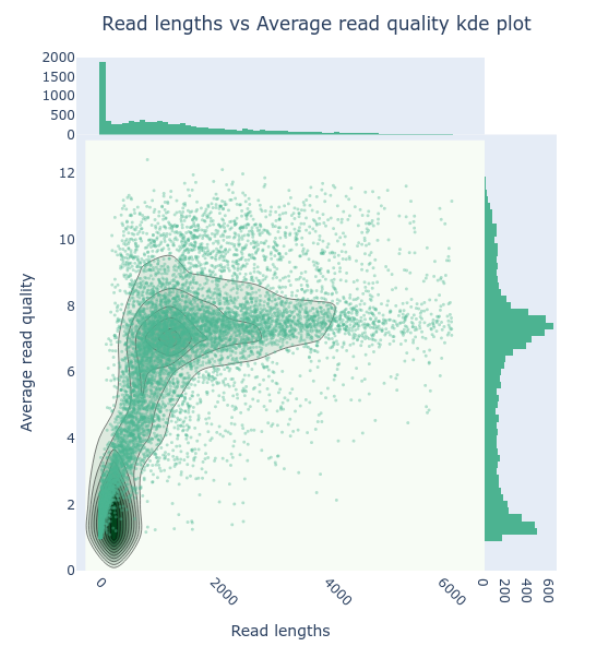


<font color="green">

### 🧩 Questions:

1. Does this figure show raw data or data already filtered by read quality?

2. Do you think is this a good quality sample? Why?

3. Considering your sample, do you think its quality is better or worse? Why?

</font>



## 5) Filtering with chopper
After QC, we may need to filter and trim the data to remove failed reads. A generic filtering usually include removing reads with short length and low average quality. In our practical we will use chopper.Chopper is a pre-processing tool that filters and normalizes long-read datasets, helping to remove extremely short or long reads and balance data for downstream analyses.

The cDNA data should be pre-processed to retain only full-length transcript reads, that is, reads covering both the 5' and 3' ends of the original cDNA molecule. This step also ensures that each read is oriented according to the coding strand of the transcript. Typically, this process involves detecting and trimming the adapter sequences introduced during library preparation. The Oxford Nanopore tool designed for this task is **Pychopper**, which classifies, orients, and removes adapters from long-read cDNA data to produce clean, full-length reads. However, we will not use Pychopper in this practical to keep the workflow lightweight and easy to run within Colab.


🧩 Filter by minimum quality/length to speed alignment. Adjust thresholds as needed (in general we work with -q 7).


In [ ]:

%%bash
set -euo pipefail
echo "Filtering reads (Q>=10, length>=500) for a quick run..."
#echo "$MYFASTQ"
zcat "$MYFASTQ" | chopper-linux -q 10 -l 500 | gzip > "data/myfastq.filtered.fastq.gz"
echo "Filtered file: data/myfastq.filtered.fastq.gz"


In [ ]:
!zcat "data/SGNex_H9_cDNA_replicate2_run4_sub.fastq.gz" | chopper-linux -q 10 -l 500 | gzip > "data/SGNex_H9_cDNA_replicate2_run4_sub_q10l500.fastq.gz"
!zcat "data/SGNex_H9_cDNA_replicate4_run4_sub.fastq.gz" | chopper-linux -q 10 -l 500 | gzip > "data/SGNex_H9_cDNA_replicate4_run4_sub_q10l500.fastq.gz"

## 6) QC with NanoPack
🧩 Run NanoPlot for basic stats and plots of filtered reads.


In [ ]:
%%bash
set -euo pipefail
echo "Running NanoStat..."
NanoStat --fastq "data/myfastq.filtered.fastq.gz" > "output/nanostat_filtered.txt"
echo "Running NanoPlot..."
mkdir -p "output/nanoplot_filtered"
NanoPlot --fastq "data/myfastq.filtered.fastq.gz" --loglength --outdir "output/nanoplot_filtered" --threads "$(nproc)"


## 7) Compare multiple fastq files with NanoComp
Comparison of the multiple fastq files could be done by NanoComp. In this case we will compare the quality of two raw and one filtered fastq files.




In [ ]:
%%bash

##edit paths and filenames as needed
NanoComp \
--fastq "data/SGNex_H9_cDNA_replicate3_run4_sub.fastq.gz" "data/myfastq.filtered.fastq.gz" "data/SGNex_H9_cDNA_replicate2_run4_sub.fastq.gz" \
--names H9_rep3 H9_rep3f H9_rep2 \
--threads "$(nproc)" \
--outdir "output/nanocomp"


Once the run is finished, the output folder will contain many figures and a summary file `NanoComp-report.html`.

<font color="green">

### 🧩 Open the summary file and inspect the results?

1. Regarding the plot *comparing average base call quality scores*, was there any read with average base quality at least 20 in your data?

2. We applied a quality filter of `-q 10`. By looking at the plot, roughly estimate whether many reads were lost and how many would have been discarded if we had used `-q 7` instead.  

3. Having a look at all plots, describe the effect of filtering the raw reds usign `-q 10 -l 500`.

</font>



## 8) Preparing the data and reference for alignment

We will align three filtered FASTQ files using minimap2, but only against chromosome 20. To do this, we will:

*  Free up space in `/content/data`.
*  Copy the filtered FASTQ files from the shared folder in Drive.
*  Copy the genomic reference files (sequence and annotation) from the shared folder in Drive.

Before starting, you can either download the files you have already generated manually or make a direct copy to your own Drive.

In [ ]:
%%bash

##copy /content/output/ to My Drive
##edit paths and directory name as needed
DEST="/content/drive/MyDrive/longread_practice2B_results"
mkdir -p "$DEST"
cp -r /content/output/* "$DEST"

In [ ]:
##BE CAREFUL, THIS LINE REMOVES EVERYTHING INSIDE /content/data
!rm /content/data/*

In [ ]:
##copy three fastq files to /content/data in Colab (e.g. three replicates of the same cell line)
!ls {SHARED_FOLDER_PATH}/fastq_filtered/SGNex_H9_cDNA_*_q10l500.fastq.gz #edit as needed
!cp {SHARED_FOLDER_PATH}/fastq_filtered/SGNex_H9_cDNA_*_q10l500.fastq.gz data/


In [ ]:
##make a new directory for genome files and copy sequence and gene annotations
%%bash
pwd
mkdir /content/hg38_chr20
ls ${SHARED_FOLDER_PATH}/hg38_chr20/*
cp ${SHARED_FOLDER_PATH}/hg38_chr20/* hg38_chr20


Now we will use `samtools` to get an index file.

In [ ]:
!samtools faidx /content/hg38_chr20/hg38_chr20.fa
!ls /content/hg38_chr20/


## 8) Alignment with **minimap2**

**Minimap2** is a fast and versatile aligner designed for mapping long sequencing reads to a reference genome or transcriptome. It is particularly well suited for long, error-prone reads generated by Oxford Nanopore or PacBio technologies, as it efficiently handles high error rates and long introns. The aligner provides several presets optimized for different data types — for instance, `-ax splice -k14` is recommended for Nanopore cDNA or direct RNA data, enabling spliced alignment, while `-ax splice:hq` is used for high-accuracy PacBio HiFi reads. In this practical, we also use `--secondary=no` to report only the primary alignment for each read, simplifying downstream counting and interpretation.



In [ ]:

%%bash
set -euo pipefail

##output folder for alignments
OUT=/content/output_bams
#mkdir -p "$OUT"

##for one fastq file (filtered with chopper)
REF=/content/hg38_chr20/hg38_chr20.fa
MYFASTQ=/content/data/SGNex_H9_cDNA_replicate2_run4_sub_q10l500.fastq.gz
BAM=/content/output_bams/H9_rep2.sorted.bam

# Spliced alignment for ONT long reads (not stranded-specific)
minimap2 -t "$(nproc)" -ax splice -k14 -G 100k --secondary=no "$REF" "$MYFASTQ" \
  | samtools view -bS - \
  | samtools sort -@ "$(nproc)" -o "$BAM"

samtools index "$BAM"
samtools flagstat "$BAM" > /content/output_bams/H9_rep2_flagstat.txt


As you may note, this process takes long time... You can kill the process and then access the already generated `bam` files in the shared folder, in the `bams` directory.

In [ ]:
!ls $SHARED_FOLDER_PATH/bams

In [ ]:
!cp $SHARED_FOLDER_PATH/bams/*.bam /content/output_bams/
!cp $SHARED_FOLDER_PATH/bams/*.bam.bai /content/output_bams/
!cp $SHARED_FOLDER_PATH/bams/*.txt /content/output_bams/

🧩 Have a look at the H9_rep2_flagstat.txt file. How many reads were mapped to chromosome 20? Additionally, you may download the `bam` and `bam.bai` files and upload them into IGV to inspect the aligned reads. The genes CST3, KIF3B and AAR2 are all located in chromosome 20. Are all them expressed in H9 cells?


## 9) Gene‑level counting with **featureCounts** (long‑read mode)
**featureCounts** is part of the **Subread** package and is widely used for counting sequencing reads that overlap annotated genomic features, such as exons or genes. It supports a dedicated long-read mode (`-L`), which correctly handles full-length spliced alignments typical of ONT or PacBio data. In this practical, we will count reads at the gene level using the `gene_id` attribute from the annotation file. Since our cDNA reads are not strand-specific, we will run featureCounts in unstranded mode (`-s 0`), ensuring that reads from either orientation are counted equally toward gene expression.


In [ ]:

%%bash
set -euo pipefail

# Paths to reference annotation and BAMs
GTF=/content/hg38_chr20/hg38_chr20_GENCODEv22.gtf
OUT=/content/output_bams/H9_featureCounts_genes.txt
BAM_DIR=/content/output_bams

# Count reads in long-read mode (-L)
# -s 0 → unstranded
# -t exon → use exon features
# -g gene_id → summarize by gene
# -T → number of threads

featureCounts -L -T "$(nproc)" -s 0 \
  -a "$GTF" -t exon -g gene_id \
  -o "$OUT" \
  "$BAM_DIR"/*.bam




In [ ]:
##Have a look at the produced files
#!head -20 /content/output_bams/H9_featureCounts_genes.txt
!cat /content/output_bams/H9_featureCounts_genes.txt | cut -f 1,7,8,9 | head


In [ ]:
##Have a look at the produced files
!cat /content/output_bams/H9_featureCounts_genes.txt.summary

Once you have the gene-level count table, you can perform differential expression (DE) analysis using tools such as `DESeq2` or `edgeR`. Multiple studies have shown a strong correlation between gene expression profiles obtained from Illumina short reads and long-read sequencing, indicating that at the gene level, both approaches produce similar results.

The main advantage of long-read sequencing is its ability to capture **full-length transcripts** and distinguish alternative isoforms, providing a more detailed view of transcript diversity. To exploit this, we can use tools such as **StringTie2** in long-read mode to quantify expression at the transcript level, enabling analyses of **differential transcript expression** and **differential transcript usage** (DTU) that go beyond standard gene-level approaches.

## 10) Transcript-level counting with **StringTie** (long-read mode)

In this section, we will use **StringTie** to estimate transcript-level expression from our long-read alignments.  
StringTie supports a dedicated **long-read mode** (`-L`) that correctly handles full-length spliced reads typical of Oxford Nanopore or PacBio sequencing.

We will use our existing BAM alignment files and a gene annotation (GTF) to:
1. Quantify expression **per transcript** and **per gene**.
2. Generate a GTF output with predicted transcripts (but see below) and an abundance table for downstream analysis.

In [ ]:
!mkdir /content/output_stringtie

In [ ]:
%%bash
set -euo pipefail

# Paths (adjust as needed)
GTF=/content/hg38_chr20/hg38_chr20_GENCODEv22.gtf
BAM_DIR=/content/output_bams
OUT_DIR=/content/output_stringtie

# Run StringTie for each BAM file
for BAM in "$BAM_DIR"/*.bam; do
  SAMPLE=$(basename "$BAM" _s.bam)
  echo ">> Processing sample: $SAMPLE"

  # -L : long-read mode
  # -G : reference annotation (guides quantification)
  # -A : gene-level abundance table
  # Output: GTF file with transcript abundances
  stringtie "$BAM" \
    -L -e -p "$(nproc)" -G "$GTF" \
    -o "$OUT_DIR/${SAMPLE}_transcripts.gtf" \
    -A "$OUT_DIR/${SAMPLE}_gene_abund.tsv"
done

In this step, we used StringTie to estimate transcript and gene abundances, but we *restricted the analysis to known transcripts already present in the annotation file*.
By adding the option `-e` (together with `-G`), we tell StringTie not to assemble new isoforms, but instead to quantify only the reference transcripts.
This makes the run much faster and ensures that all samples are quantified consistently using the same set of annotated transcripts — in our case, limited to chromosome 20.

In [ ]:
##have a look at gene expression estimates
!head -10 /content/output_stringtie/H9_rep2_gene_abund.tsv

In [ ]:
##have a look at gene and transcript quantifications
!head -10 /content/output_stringtie/H9_rep2_transcripts.gtf

To continue the analysis with other tools, you can use the [prepDE.py](https://raw.githubusercontent.com/gpertea/stringtie/master/prepDE.py) script provided with StringTie to generate expression tables at the gene and transcript levels.
These tables contain raw counts that can be used as input for downstream analyses such as differential gene expression (DGE), differential transcript expression (DTE), or differential transcript usage (DTU) with tools like `DESeq2`, `edgeR`, `DRIMSeq`, or `satuRn`.
In the next notebook, however, we will use `bambu`, which integrates transcript quantification and differential analysis in a single framework.